In [2]:
import sqlite3

def create_sample_database(large_db_path, sample_db_path, percentage):
    # Connect to the existing large database
    large_conn = sqlite3.connect(large_db_path)
    large_cursor = large_conn.cursor()
    
    # Get the total number of rows in the large database
    large_cursor.execute("SELECT COUNT(*) FROM customers")
    total_rows = large_cursor.fetchone()[0]
    
    # Calculate the number of rows for the sample based on the percentage
    sample_size = int((percentage / 100) * total_rows)
    
    # Fetch random rows from the large database
    large_cursor.execute(f"SELECT * FROM customers ORDER BY RANDOM() LIMIT {sample_size}")
    rows = large_cursor.fetchall()
    
    # Create the sample database and its table
    sample_conn = sqlite3.connect(sample_db_path)
    sample_cursor = sample_conn.cursor()
    sample_cursor.execute('''
    CREATE TABLE IF NOT EXISTS customers (
        id TEXT PRIMARY KEY,
        name TEXT,
        email TEXT,
        address TEXT,
        phone_number TEXT,
        job TEXT,
        company TEXT,
        date_of_birth TEXT,
        ssn TEXT,
        credit_card_number TEXT,
        credit_card_expire TEXT,
        credit_card_provider TEXT,
        bank_country TEXT,
        currency_code TEXT,
        amount REAL,
        transaction_date TEXT
    )
    ''')
    
    # Insert the fetched rows into the sample database
    for row in rows:
        sample_cursor.execute('''
        INSERT INTO customers (
            id, name, email, address, phone_number, job, company, date_of_birth, ssn,
            credit_card_number, credit_card_expire, credit_card_provider, bank_country,
            currency_code, amount, transaction_date
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', row)
    
    sample_conn.commit()
    sample_conn.close()
    large_conn.close()
    print(f"Sample database '{sample_db_path}' created with {sample_size} rows ({percentage}%).")

if __name__ == "__main__":
    large_db_path = "large_database.db"
    
    # Create sample databases for 5%, 10%, 15%, and 20%
    for pct in [5, 10, 15, 20]:
        sample_db_path = f"sample_database_{pct}p.db"
        create_sample_database(large_db_path, sample_db_path, percentage=pct)


Sample database 'sample_database_5p.db' created with 20000 rows (5%).
Sample database 'sample_database_10p.db' created with 40000 rows (10%).
Sample database 'sample_database_15p.db' created with 60000 rows (15%).
Sample database 'sample_database_20p.db' created with 80000 rows (20%).


In [15]:
import requests
import json
import sqlite3
import time

# Define the URL for the API
url = "http://localhost:8000/v1/chat/completions"

# Global variables to store metrics
gold_standard_metrics = {}         # Dictionary: key = SQL query, value = (execution_time, aggregate_value)
sample_5_metrics = []              # List of dictionaries
sample_10_metrics = []             # List of tuples: (query, execution_time, abs_error, percent_error, scaled_result, scaling_factor)
sample_15_metrics = {}             # Dictionary: key = SQL query, value = {metrics...}
sample_20_metrics = []             # List of tuples: (query, execution_time, abs_error, percent_error, scaled_result, scaling_factor)

# Global list to log raw execution times for debugging
time_detailsSM1 = []

# Set up the headers for API requests
headers = {
    "Content-Type": "application/json"
}

def ask_model(prompt):
    data = {
        "model": "defog/llama-3-sqlcoder-8b",  # Updated model name
        "temperature": 0.0001,  # Lower value for deterministic responses
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(url, headers=headers, data=json.dumps(data))
    if response.status_code == 200:
        model_output = response.json()["choices"][0]["message"]["content"]
        print("\n🔍 Model Raw Output:\n", model_output)
        return model_output
    else:
        raise Exception(f"API request failed with status code {response.status_code}")

def natural_language_to_sql(user_command):
    prompt = f"""
    ### Task:
Convert the following natural language command into a correctly formatted SQLite SQL query.

### Important Notes:
1. Use only SQLite-compatible functions. SQLite does NOT support the following functions:
   - `EXTRACT`
   - `AGE`
   - `TO_DATE`
   - `DATE_PART`
   - `DATE_TRUNC`
2. For date calculations, use SQLite's `julianday` function.
3. Return ONLY the SQL query. NO explanations, NO markdown (`sql ... `), NO descriptions.
4. The output must be a direct SQL query, formatted correctly for SQLite.
5. Do NOT include anything else.

### Database Schema:
Table: customers
Columns:
  - id (TEXT, PRIMARY KEY)
  - name (TEXT)
  - email (TEXT)
  - address (TEXT)
  - phone_number (TEXT)
  - job (TEXT)
  - company (TEXT)
  - date_of_birth (TEXT)
  - ssn (TEXT)
  - credit_card_number (TEXT)
  - credit_card_expire (TEXT)
  - credit_card_provider (TEXT)
  - bank_country (TEXT)
  - currency_code (TEXT)
  - amount (REAL)
  - transaction_date (TEXT)

### Examples:
**User Input:** What is the total number of customers?
**SQL Output:** SELECT COUNT(*) FROM customers;

**User Input:** What is the total value of all transactions?
**SQL Output:** SELECT SUM(amount) FROM customers;

**User Input:** Show all customers born after 1990 in the USA.
**SQL Output:** SELECT name FROM customers WHERE date_of_birth > '1990-01-01' AND bank_country = 'USA';

**User Input:** What is the average age of customers?
**SQL Output:** SELECT AVG((julianday('now') - julianday(date_of_birth)) / 365.25) AS average_age FROM customers;

### User Input:
{user_command}

### SQL Output:
    """
    response = ask_model(prompt)
    if response.strip().upper().startswith("SELECT") and response.strip().endswith(";"):
        sql_query = response.strip()
    else:
        print("⚠️ Warning: Model response did not return a valid SQL query. Retrying with fallback.")
        sql_query = "SELECT * FROM customers LIMIT 5;"  # Safe fallback
    return sql_query

def compute_scaling_factor(small_db_path, large_db_path):
    """
    Computes the scaling factor as the ratio of the number of rows in the large database 
    to the number of rows in the small database.
    """
    try:
        # Count rows in small database
        small_conn = sqlite3.connect(small_db_path)
        small_cursor = small_conn.cursor()
        small_cursor.execute("SELECT COUNT(*) FROM customers")
        small_count = small_cursor.fetchone()[0]
        small_conn.close()

        # Count rows in large database
        large_conn = sqlite3.connect(large_db_path)
        large_cursor = large_conn.cursor()
        large_cursor.execute("SELECT COUNT(*) FROM customers")
        large_count = large_cursor.fetchone()[0]
        large_conn.close()

        if small_count > 0:
            return large_count / small_count
        else:
            return 1
    except Exception as e:
        print(f"Error computing scaling factor: {e}")
        return 1

def execute_sql(database_path, sql_query, scaling_factor=1):
    """
    Executes the given SQL query on a specified database and applies scaling (for SUM/COUNT).
    Returns the (possibly scaled) result and the execution time.
    """
    try:
        conn = sqlite3.connect(database_path)
        cursor = conn.cursor()
        print(f"\n🔍 Executing SQL Query on {database_path} ...")
        start_time = time.time()
        cursor.execute(sql_query)
        results = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        end_time = time.time()
        execution_time = end_time - start_time

        # Log raw execution details
        time_detailsSM1.append({
            "Database": database_path,
            "Query": sql_query,
            "Execution Time": execution_time
        })
        
        # Apply scaling for aggregate functions (avoid scaling AVG)
        if scaling_factor > 1:
            query_upper = sql_query.upper()
            if ("SUM(" in query_upper or "COUNT(" in query_upper) and "AVG(" not in query_upper:
                if len(results) == 1 and len(results[0]) == 1 and isinstance(results[0][0], (int, float)):
                    results = [[results[0][0] * scaling_factor]]
                else:
                    new_results = []
                    for row in results:
                        row_list = list(row)
                        if len(row_list) >= 2 and isinstance(row_list[1], (int, float)):
                            row_list[1] *= scaling_factor
                        elif len(row_list) == 1 and isinstance(row_list[0], (int, float)):
                            row_list[0] *= scaling_factor
                        new_results.append(tuple(row_list))
                    results = new_results

        conn.close()
        return results, execution_time
    except sqlite3.Error as e:
        print(f"⚠️ SQL Error: {e}")
        return None, 0
    except Exception as e:
        print(f"⚠️ Unexpected Error: {e}")
        return None, 0

def compute_accuracy(gold_value, sample_value):
    """
    Computes absolute error and percentage error between the gold standard value
    and the sample value.
    """
    try:
        error = abs(gold_value - sample_value)
        percent_error = (error / gold_value * 100) if gold_value != 0 else 0
        return error, percent_error
    except Exception as e:
        print(f"Error computing accuracy: {e}")
        return None, None

def run_experiment(sql_query, large_db_path, sample_db_paths):
    """
    Runs the query on the large database (gold standard) and on each sample database,
    then stores execution time and accuracy metrics in different global data structures.
    """
    global gold_standard_metrics, sample_5_metrics, sample_10_metrics, sample_15_metrics, sample_20_metrics

    # Run on the large (gold standard) database
    gold_results, gold_time = execute_sql(large_db_path, sql_query, scaling_factor=1)
    try:
        gold_value = float(gold_results[0][0]) if gold_results and isinstance(gold_results[0][0], (int, float)) else None
    except Exception:
        gold_value = None

    # Store gold standard metrics in a dictionary (keyed by query)
    gold_standard_metrics[sql_query] = (gold_time, gold_value)
    print("\n--- Gold Standard (Large Database) ---")
    print(f"Execution Time: {gold_time:.4f} sec")
    if gold_value is not None:
        print(f"Aggregate Result: {gold_value}")
    else:
        print("Non-numeric or multi-valued result; accuracy cannot be computed.")

    # Run experiments on sample databases
    for label, sample_db_path in sample_db_paths.items():
        scaling_factor = compute_scaling_factor(sample_db_path, large_db_path)
        sample_results, sample_time = execute_sql(sample_db_path, sql_query, scaling_factor=scaling_factor)
        try:
            sample_value = float(sample_results[0][0]) if sample_results and isinstance(sample_results[0][0], (int, float)) else None
        except Exception:
            sample_value = None
        
        # Compute accuracy if possible
        if gold_value is not None and sample_value is not None:
            abs_error, percent_error = compute_accuracy(gold_value, sample_value)
        else:
            abs_error, percent_error = None, None

        print(f"\n--- Sample Database ({label}) ---")
        print(f"Scaling Factor: {scaling_factor:.2f}")
        print(f"Execution Time: {sample_time:.4f} sec")
        if gold_value is not None and sample_value is not None:
            print(f"Scaled Aggregate Result: {sample_value}")
            print(f"Absolute Error: {abs_error:.2f}")
            print(f"Percentage Error: {percent_error:.2f}%")
        else:
            print("Non-numeric or multi-valued result; accuracy cannot be computed.")

        # Store metrics in different data structures based on dataset label
        if label == "5%":
            # Store as a dictionary and append to a list
            sample_5_metrics.append({
                "Query": sql_query,
                "Execution Time": sample_time,
                "Scaling Factor": scaling_factor,
                "Scaled Result": sample_value,
                "Absolute Error": abs_error,
                "Percentage Error": percent_error
            })
        elif label == "10%":
            # Store as a tuple
            sample_10_metrics.append((sql_query, sample_time, abs_error, percent_error, sample_value, scaling_factor))
        elif label == "15%":
            # Store in a dictionary keyed by query
            sample_15_metrics[sql_query] = {
                "Execution Time": sample_time,
                "Scaling Factor": scaling_factor,
                "Scaled Result": sample_value,
                "Absolute Error": abs_error,
                "Percentage Error": percent_error
            }
        elif label == "20%":
            # Store as a tuple in a list
            sample_20_metrics.append((sql_query, sample_time, abs_error, percent_error, sample_value, scaling_factor))

def main():
    # Define database paths
    large_db_path = "large_database.db"
    sample_db_paths = {
        "5%": "sample_database_5p.db",
        "10%": "sample_database_10p.db",
        "15%": "sample_database_15p.db",
        "20%": "sample_database_20p.db"
    }

    while True:
        user_command = input("\nEnter your query (or type 'exit' to quit): ")
        if user_command.lower() == "exit":
            break
        sql_query = natural_language_to_sql(user_command)
        print(f"\n📝 Generated SQL Query:\n{sql_query}")

        # Run the experiment on all datasets and store metrics in globals
        run_experiment(sql_query, large_db_path, sample_db_paths)

        # Optionally, print a summary of raw execution times logged
        print("\n--- Raw Execution Time Log ---")
        for detail in time_detailsSM1:
            print(f"Database: {detail['Database']}, Execution Time: {detail['Execution Time']:.4f} sec")

if __name__ == "__main__":
    main()



Enter your query (or type 'exit' to quit):  What is the total number of customers?



🔍 Model Raw Output:
 SELECT COUNT(*) FROM customers;

📝 Generated SQL Query:
SELECT COUNT(*) FROM customers;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 1.4304 sec
Aggregate Result: 400000.0

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0408 sec
Scaled Aggregate Result: 400000.0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0885 sec
Scaled Aggregate Result: 400000.0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.1076 sec
Scaled Aggregate Result: 400000.0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_20p.db ...

--- Sample Database (20%) ---
Scaling Factor: 5.00
Execution 


Enter your query (or type 'exit' to quit):  What is the sum of all transaction amounts?



🔍 Model Raw Output:
 SELECT SUM(amount) FROM customers;

📝 Generated SQL Query:
SELECT SUM(amount) FROM customers;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.6202 sec
Aggregate Result: 2018540615.8300211

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0474 sec
Scaled Aggregate Result: 2026127698.9999962
Absolute Error: 7587083.17
Percentage Error: 0.38%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0982 sec
Scaled Aggregate Result: 2015572439.8000028
Absolute Error: 2968176.03
Percentage Error: 0.15%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.1258 sec
Scaled Aggregate Result: 2021372146.599977
Absolute Error: 2831530.77
Percentage Error: 0.14%

🔍 Executing SQL Query on sample_database_20p.db ...


Enter your query (or type 'exit' to quit):  What is the maximum transaction amount recorded?



🔍 Model Raw Output:
 SELECT MAX(amount) FROM customers;

📝 Generated SQL Query:
SELECT MAX(amount) FROM customers;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.2127 sec
Aggregate Result: 9999.99

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0103 sec
Scaled Aggregate Result: 9999.8
Absolute Error: 0.19
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0169 sec
Scaled Aggregate Result: 9999.97
Absolute Error: 0.02
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.0246 sec
Scaled Aggregate Result: 9999.63
Absolute Error: 0.36
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_20p.db ...

--- Sample Database (20%) ---
Scaling Factor: 5.00
Execution


Enter your query (or type 'exit' to quit):  What is the average transaction amount?



🔍 Model Raw Output:
 SELECT AVG(amount) FROM customers;

📝 Generated SQL Query:
SELECT AVG(amount) FROM customers;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.4422 sec
Aggregate Result: 5046.351539575053

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0108 sec
Scaled Aggregate Result: 5065.3192474999905
Absolute Error: 18.97
Percentage Error: 0.38%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.1058 sec
Scaled Aggregate Result: 5038.931099500007
Absolute Error: 7.42
Percentage Error: 0.15%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.0807 sec
Scaled Aggregate Result: 5053.4303664999425
Absolute Error: 7.08
Percentage Error: 0.14%

🔍 Executing SQL Query on sample_database_20p.db ...

--- Sample Datab


Enter your query (or type 'exit' to quit):  How many customers were born after 1990?



🔍 Model Raw Output:
 SELECT COUNT(*) FROM customers WHERE date_of_birth > '1990-01-01';

📝 Generated SQL Query:
SELECT COUNT(*) FROM customers WHERE date_of_birth > '1990-01-01';

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.2597 sec
Aggregate Result: 121593.0

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0115 sec
Scaled Aggregate Result: 120840.0
Absolute Error: 753.00
Percentage Error: 0.62%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0246 sec
Scaled Aggregate Result: 121850.0
Absolute Error: 257.00
Percentage Error: 0.21%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.0895 sec
Scaled Aggregate Result: 121180.0
Absolute Error: 413.00
Percentage Error: 0.34%

🔍 Executing SQL Query on sample_databa


Enter your query (or type 'exit' to quit):  What is the total transaction amount for customers in the Korea?



🔍 Model Raw Output:
 SELECT SUM(amount) FROM customers WHERE bank_country = 'Korea';

📝 Generated SQL Query:
SELECT SUM(amount) FROM customers WHERE bank_country = 'Korea';

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.3952 sec
Aggregate Result: 16559258.13000001

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0525 sec
Scaled Aggregate Result: 18572833.000000004
Absolute Error: 2013574.87
Percentage Error: 12.16%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0210 sec
Scaled Aggregate Result: 18076772.899999987
Absolute Error: 1517514.77
Percentage Error: 9.16%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.0352 sec
Scaled Aggregate Result: 16120363.266666666
Absolute Error: 438894.86
Percentage Error: 


Enter your query (or type 'exit' to quit):  What is the maximum transaction amount for customers whose job title contains ‘Manager’?



🔍 Model Raw Output:
 SELECT MAX(amount) FROM customers WHERE job LIKE '%Manager%';

📝 Generated SQL Query:
SELECT MAX(amount) FROM customers WHERE job LIKE '%Manager%';

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.5070 sec
Aggregate Result: 9999.8

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0100 sec
Scaled Aggregate Result: 9997.72
Absolute Error: 2.08
Percentage Error: 0.02%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.1037 sec
Scaled Aggregate Result: 9995.24
Absolute Error: 4.56
Percentage Error: 0.05%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.1374 sec
Scaled Aggregate Result: 9998.96
Absolute Error: 0.84
Percentage Error: 0.01%

🔍 Executing SQL Query on sample_database_20p.db ...

--- Sa


Enter your query (or type 'exit' to quit):  Group the customers by bank country and show the total transaction amount for each country



🔍 Model Raw Output:
 SELECT bank_country, SUM(amount) AS total_transaction_amount FROM customers GROUP BY bank_country;

📝 Generated SQL Query:
SELECT bank_country, SUM(amount) AS total_transaction_amount FROM customers GROUP BY bank_country;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 1.7757 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0524 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.1207 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.2189 sec
Non-numeric or multi-valued result; accuracy canno


Enter your query (or type 'exit' to quit):  For each currency code, what is the total value of transactions?



🔍 Model Raw Output:
 SELECT c.currency_code, SUM(c.amount) AS total_transaction_amount FROM customers c GROUP BY c.currency_code ORDER BY total_transaction_amount DESC NULLS LAST;

📝 Generated SQL Query:
SELECT c.currency_code, SUM(c.amount) AS total_transaction_amount FROM customers c GROUP BY c.currency_code ORDER BY total_transaction_amount DESC NULLS LAST;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.4413 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0158 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0395 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_15p.db ...

--- Samp


Enter your query (or type 'exit' to quit):  List each credit card provider with the total number of transactions processed



🔍 Model Raw Output:
 SELECT credit_card_provider, COUNT(*) AS total_transactions FROM customers GROUP BY credit_card_provider ORDER BY total_transactions DESC NULLS LAST;

📝 Generated SQL Query:
SELECT credit_card_provider, COUNT(*) AS total_transactions FROM customers GROUP BY credit_card_provider ORDER BY total_transactions DESC NULLS LAST;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.3324 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0164 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0339 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) 


Enter your query (or type 'exit' to quit):  What is the sum of all transactions for customers in Canada who were born after 1980?



🔍 Model Raw Output:
 SELECT SUM(c.amount) FROM customers c WHERE c.bank_country = 'Canada' AND julianday('now') - julianday(c.date_of_birth) > 1980;

📝 Generated SQL Query:
SELECT SUM(c.amount) FROM customers c WHERE c.bank_country = 'Canada' AND julianday('now') - julianday(c.date_of_birth) > 1980;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.9180 sec
Aggregate Result: 7771747.10000001

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0692 sec
Scaled Aggregate Result: 7221883.199999999
Absolute Error: 549863.90
Percentage Error: 7.08%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0927 sec
Scaled Aggregate Result: 7423620.9
Absolute Error: 348126.20
Percentage Error: 4.48%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
E


Enter your query (or type 'exit' to quit):  Group customers by job title and show the average transaction amount for those born after 1990.



🔍 Model Raw Output:
 SELECT c.job, AVG(c.amount) AS average_transaction_amount FROM customers c WHERE c.date_of_birth > '1990-01-01' GROUP BY c.job ORDER BY average_transaction_amount DESC NULLS LAST;

📝 Generated SQL Query:
SELECT c.job, AVG(c.amount) AS average_transaction_amount FROM customers c WHERE c.date_of_birth > '1990-01-01' GROUP BY c.job ORDER BY average_transaction_amount DESC NULLS LAST;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.9633 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0630 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.1607 sec
Non-numeric or multi-valued result; accuracy cannot be computed.

🔍 Executing SQL Que


Enter your query (or type 'exit' to quit):  exit


Displaying Results for single queries

/tmp/slurmtmp.34279937/ipykernel_87935/4067949783.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


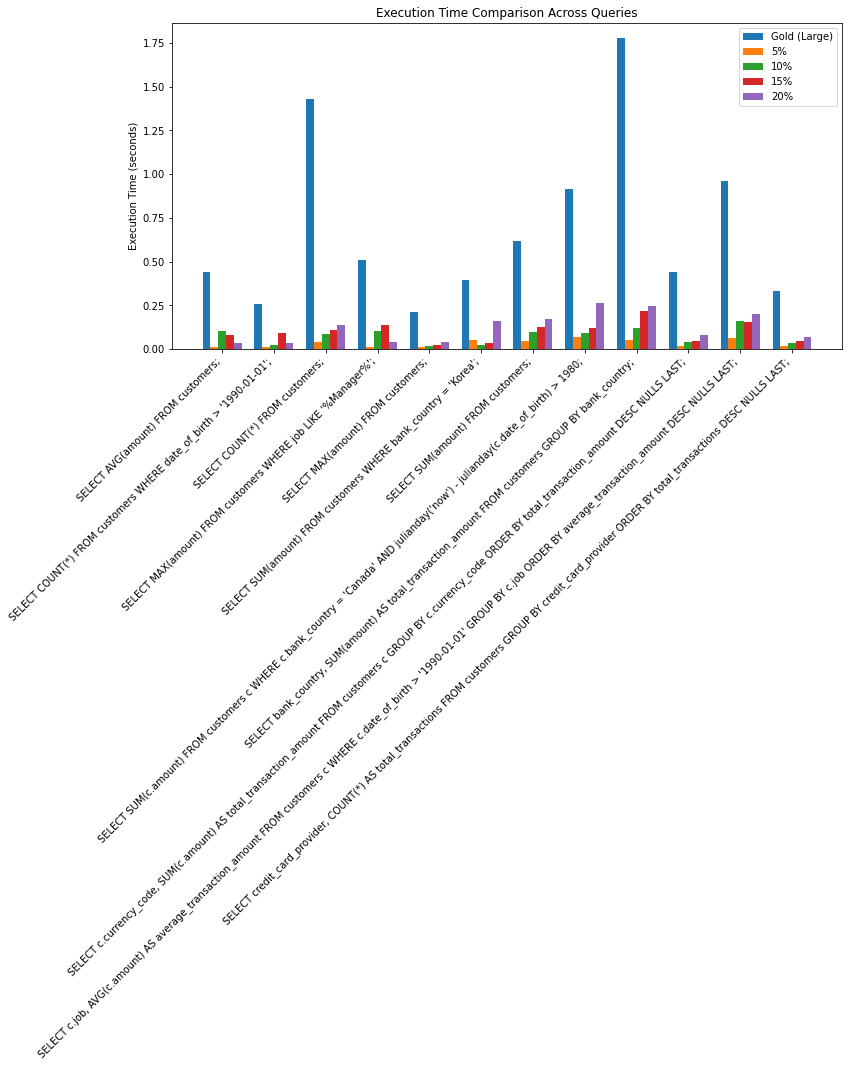

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_all_metrics():
    # Get all unique queries from the gold standard metrics
    queries = list(gold_standard_metrics.keys())
    queries.sort()  # optional: sort alphabetically

    # Initialize lists to hold execution times for each dataset.
    gold_times = []
    sample5_times = []
    sample10_times = []
    sample15_times = []
    sample20_times = []

    for query in queries:
        # For Gold standard (Large Database)
        gold_time, _ = gold_standard_metrics.get(query, (None, None))
        gold_times.append(gold_time if gold_time is not None else 0)

        # For Sample 5% (list of dicts)
        s5 = next((item for item in sample_5_metrics if item.get("Query") == query), None)
        sample5_times.append(s5["Execution Time"] if s5 else 0)

        # For Sample 10% (list of tuples: (query, exec_time, abs_error, percent_error, scaled_result, scaling_factor))
        s10 = next((item for item in sample_10_metrics if item[0] == query), None)
        sample10_times.append(s10[1] if s10 else 0)

        # For Sample 15% (dictionary keyed by query)
        s15 = sample_15_metrics.get(query, None)
        sample15_times.append(s15["Execution Time"] if s15 else 0)

        # For Sample 20% (list of tuples)
        s20 = next((item for item in sample_20_metrics if item[0] == query), None)
        sample20_times.append(s20[1] if s20 else 0)

    # Prepare x-axis positions for the grouped bars.
    x = np.arange(len(queries))
    bar_width = 0.15

    # Plot Execution Time Comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - 2 * bar_width, gold_times, bar_width, label='Gold (Large)')
    rects2 = ax.bar(x - bar_width, sample5_times, bar_width, label='5%')
    rects3 = ax.bar(x, sample10_times, bar_width, label='10%')
    rects4 = ax.bar(x + bar_width, sample15_times, bar_width, label='15%')
    rects5 = ax.bar(x + 2 * bar_width, sample20_times, bar_width, label='20%')

    ax.set_ylabel("Execution Time (seconds)")
    ax.set_title("Execution Time Comparison Across Queries")
    ax.set_xticks(x)
    ax.set_xticklabels(queries, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.savefig("timeTaken.png") 
    plt.show()

# Call the visualization function after running your experiments.
visualize_all_metrics()


/tmp/slurmtmp.34279937/ipykernel_87935/230777357.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


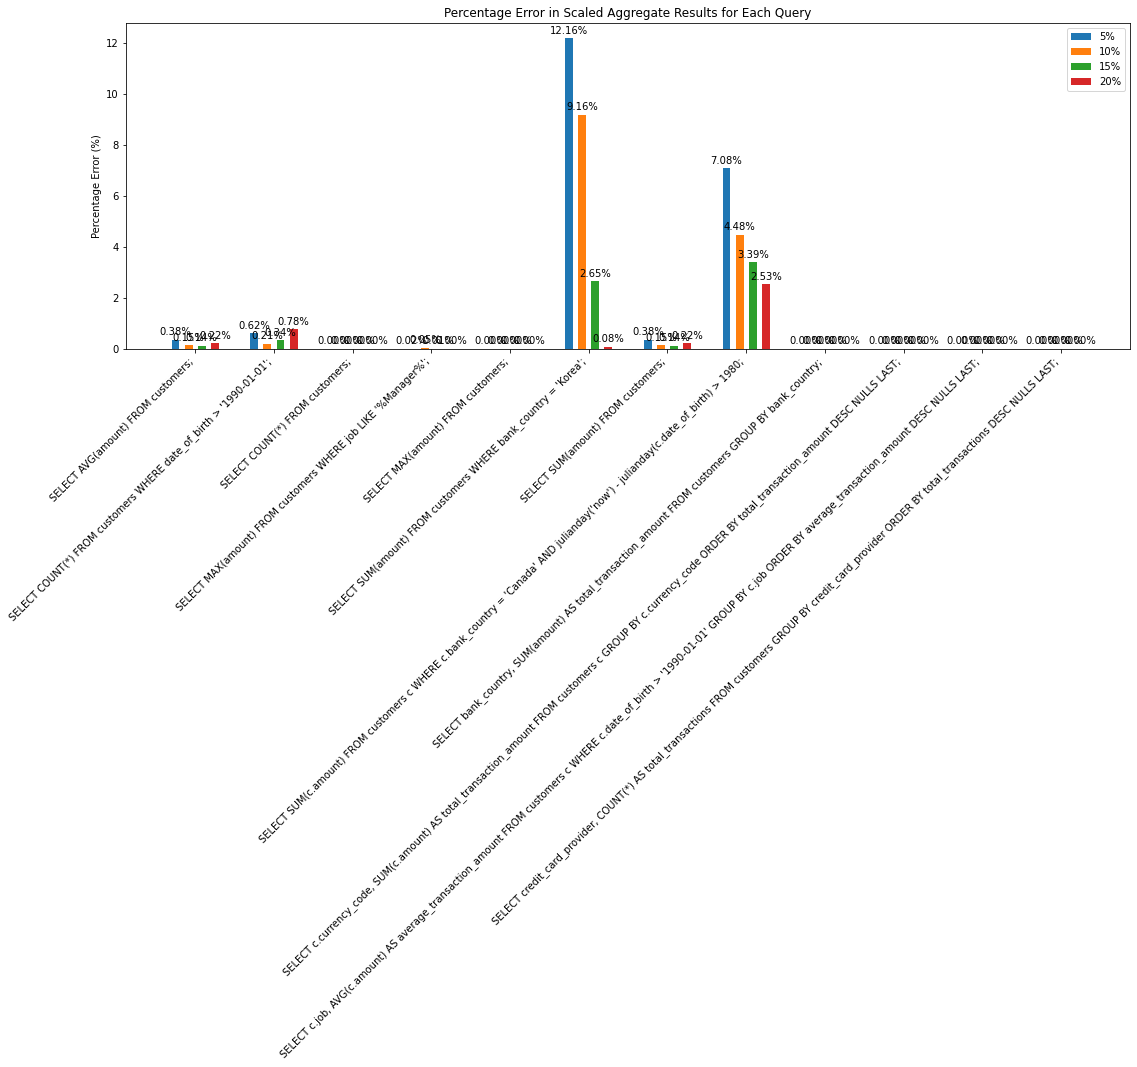

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_accuracy_all():
    # Retrieve all queries (gold standard keys)
    queries = list(gold_standard_metrics.keys())
    queries.sort()  # Optionally sort the queries

    # Initialize lists to hold the percentage error for each sample dataset
    sample5_errors = []
    sample10_errors = []
    sample15_errors = []
    sample20_errors = []

    # Loop over each query and extract the corresponding percentage error from each sample
    for query in queries:
        # For 5% sample (list of dictionaries)
        s5 = next((item for item in sample_5_metrics if item.get("Query") == query), None)
        sample5_errors.append(s5["Percentage Error"] if s5 and s5["Percentage Error"] is not None else 0)
        
        # For 10% sample (list of tuples: (query, exec_time, abs_error, percent_error, scaled_result, scaling_factor))
        s10 = next((item for item in sample_10_metrics if item[0] == query), None)
        sample10_errors.append(s10[3] if s10 and s10[3] is not None else 0)
        
        # For 15% sample (dictionary keyed by query)
        s15 = sample_15_metrics.get(query, None)
        sample15_errors.append(s15["Percentage Error"] if s15 and s15["Percentage Error"] is not None else 0)
        
        # For 20% sample (list of tuples)
        s20 = next((item for item in sample_20_metrics if item[0] == query), None)
        sample20_errors.append(s20[3] if s20 and s20[3] is not None else 0)

    # Increase spacing between groups by multiplying x positions by a factor
    group_spacing = 3.0  # This determines the space between query groups
    num_groups = len(queries)
    x_group_centers = np.arange(num_groups) * group_spacing

    # Parameters for bars within each group
    bar_width = 0.3
    gap = 0.2
    # Total width of the cluster = 4*bar_width + 3*gap
    total_cluster_width = 4 * bar_width + 3 * gap
    # Left offset (from center) to the center of the first bar:
    left_offset = total_cluster_width / 2

    # Compute positions for each bar within each group:
    # Position of first bar = group_center - left_offset + half bar width
    pos_5 = x_group_centers - left_offset + bar_width/2
    pos_10 = pos_5 + (bar_width + gap)
    pos_15 = pos_10 + (bar_width + gap)
    pos_20 = pos_15 + (bar_width + gap)

    fig, ax = plt.subplots(figsize=(18, 6))
    
    rects5 = ax.bar(pos_5, sample5_errors, bar_width, label='5%')
    rects10 = ax.bar(pos_10, sample10_errors, bar_width, label='10%')
    rects15 = ax.bar(pos_15, sample15_errors, bar_width, label='15%')
    rects20 = ax.bar(pos_20, sample20_errors, bar_width, label='20%')
    
    ax.set_ylabel("Percentage Error (%)")
    ax.set_title("Percentage Error in Scaled Aggregate Results for Each Query")
    # Set x-ticks at the center of each group
    ax.set_xticks(x_group_centers)
    ax.set_xticklabels(queries, rotation=45, ha='right')
    ax.legend()
    
    # Add annotations on top of each bar
    for rect_group in [rects5, rects10, rects15, rects20]:
        for rect in rect_group:
            height = rect.get_height()
            ax.annotate(f"{height:.2f}%",
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom")

    fig.tight_layout()
    plt.savefig("Accuracy.png") 
    plt.show()

# Call the visualization function to see the grouped bar chart for accuracy across all queries.
visualize_accuracy_all()


Multi query accuracy and execution time

In [18]:
import requests
import json
import sqlite3
import time

# Define the URL for the API
url = "http://localhost:8000/v1/chat/completions"

# Global variables to store metrics for multi-numerical queries (single aggregate value)
gold_standard_metrics = {}         # Dictionary: key = SQL query, value = (execution_time, aggregate_value)
sample_5_metrics = []              # List of dictionaries
sample_10_metrics = []             # List of tuples: (query, execution_time, abs_error, percent_error, aggregated_sample_value, scaling_factor)
sample_15_metrics = {}             # Dictionary: key = SQL query, value = {metrics...}
sample_20_metrics = []             # List of tuples: (query, execution_time, abs_error, percent_error, aggregated_sample_value, scaling_factor)

# Global list to log raw execution times for debugging
time_detailsSM1 = []

# Set up the headers for API requests
headers = {
    "Content-Type": "application/json"
}

def ask_model(prompt):
    data = {
        "model": "defog/llama-3-sqlcoder-8b",  # Updated model name
        "temperature": 0.0001,  # Lower value for deterministic responses
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(url, headers=headers, data=json.dumps(data))
    if response.status_code == 200:
        model_output = response.json()["choices"][0]["message"]["content"]
        print("\n🔍 Model Raw Output:\n", model_output)
        return model_output
    else:
        raise Exception(f"API request failed with status code {response.status_code}")

def natural_language_to_sql(user_command):
    prompt = f"""
    ### Task:
Convert the following natural language command into a correctly formatted SQLite SQL query.

### Important Notes:
1. Use only SQLite-compatible functions. SQLite does NOT support the following functions:
   - `EXTRACT`
   - `AGE`
   - `TO_DATE`
   - `DATE_PART`
   - `DATE_TRUNC`
2. For date calculations, use SQLite's `julianday` function.
3. Return ONLY the SQL query. NO explanations, NO markdown (`sql ... `), NO descriptions.
4. The output must be a direct SQL query, formatted correctly for SQLite.
5. Do NOT include anything else.

### Database Schema:
Table: customers
Columns:
  - id (TEXT, PRIMARY KEY)
  - name (TEXT)
  - email (TEXT)
  - address (TEXT)
  - phone_number (TEXT)
  - job (TEXT)
  - company (TEXT)
  - date_of_birth (TEXT)
  - ssn (TEXT)
  - credit_card_number (TEXT)
  - credit_card_expire (TEXT)
  - credit_card_provider (TEXT)
  - bank_country (TEXT)
  - currency_code (TEXT)
  - amount (REAL)
  - transaction_date (TEXT)

### Examples:
**User Input:** What is the total number of customers?
**SQL Output:** SELECT COUNT(*) FROM customers;

**User Input:** What is the total value of all transactions?
**SQL Output:** SELECT SUM(amount) FROM customers;

**User Input:** Show all customers born after 1990 in the USA.
**SQL Output:** SELECT name FROM customers WHERE date_of_birth > '1990-01-01' AND bank_country = 'USA';

**User Input:** What is the average age of customers?
**SQL Output:** SELECT AVG((julianday('now') - julianday(date_of_birth)) / 365.25) AS average_age FROM customers;

### User Input:
{user_command}

### SQL Output:
    """
    response = ask_model(prompt)
    if response.strip().upper().startswith("SELECT") and response.strip().endswith(";"):
        sql_query = response.strip()
    else:
        print("⚠️ Warning: Model response did not return a valid SQL query. Retrying with fallback.")
        sql_query = "SELECT * FROM customers LIMIT 5;"  # Safe fallback
    return sql_query

def compute_scaling_factor(small_db_path, large_db_path):
    """
    Computes the scaling factor as the ratio of the number of rows in the large database 
    to the number of rows in the small database.
    """
    try:
        small_conn = sqlite3.connect(small_db_path)
        small_cursor = small_conn.cursor()
        small_cursor.execute("SELECT COUNT(*) FROM customers")
        small_count = small_cursor.fetchone()[0]
        small_conn.close()

        large_conn = sqlite3.connect(large_db_path)
        large_cursor = large_conn.cursor()
        large_cursor.execute("SELECT COUNT(*) FROM customers")
        large_count = large_cursor.fetchone()[0]
        large_conn.close()

        if small_count > 0:
            return large_count / small_count
        else:
            return 1
    except Exception as e:
        print(f"Error computing scaling factor: {e}")
        return 1

def execute_sql(database_path, sql_query, scaling_factor=1):
    """
    Executes the given SQL query on a specified database and applies scaling (for SUM/COUNT).
    Returns the (possibly scaled) result list and the execution time.
    """
    try:
        conn = sqlite3.connect(database_path)
        cursor = conn.cursor()
        print(f"\n🔍 Executing SQL Query on {database_path} ...")
        start_time = time.time()
        cursor.execute(sql_query)
        results = cursor.fetchall()
        end_time = time.time()
        execution_time = end_time - start_time

        time_detailsSM1.append({
            "Database": database_path,
            "Query": sql_query,
            "Execution Time": execution_time
        })

        # Apply scaling for aggregate functions (avoid scaling AVG)
        if scaling_factor > 1:
            query_upper = sql_query.upper()
            if ("SUM(" in query_upper or "COUNT(" in query_upper) and "AVG(" not in query_upper:
                if len(results) == 1 and len(results[0]) == 1 and isinstance(results[0][0], (int, float)):
                    results = [[results[0][0] * scaling_factor]]
                else:
                    new_results = []
                    for row in results:
                        row_list = list(row)
                        if len(row_list) >= 2 and isinstance(row_list[1], (int, float)):
                            row_list[1] *= scaling_factor
                        elif len(row_list) == 1 and isinstance(row_list[0], (int, float)):
                            row_list[0] *= scaling_factor
                        new_results.append(tuple(row_list))
                    results = new_results

        conn.close()
        return results, execution_time
    except sqlite3.Error as e:
        print(f"⚠️ SQL Error: {e}")
        return None, 0
    except Exception as e:
        print(f"⚠️ Unexpected Error: {e}")
        return None, 0

def aggregate_results(results):
    """
    Aggregates the results by summing the first column of each row.
    Returns a single numerical value.
    """
    try:
        return sum(row[0] for row in results if isinstance(row[0], (int, float)))
    except Exception as e:
        print(f"Error aggregating results: {e}")
        return None

def compute_accuracy(gold_value, sample_value):
    """
    Computes absolute error and percentage error between the gold standard value
    and the sample value.
    """
    try:
        error = abs(gold_value - sample_value)
        percent_error = (error / gold_value * 100) if gold_value != 0 else 0
        return error, percent_error
    except Exception as e:
        print(f"Error computing accuracy: {e}")
        return None, None

def run_experiment(sql_query, large_db_path, sample_db_paths):
    """
    Runs the query on the large database (gold standard) and on each sample database.
    For multi-row results, aggregates the values into a single numerical value before computing accuracy.
    Stores execution time and accuracy metrics in global data structures.
    """
    global gold_standard_metrics, sample_5_metrics, sample_10_metrics, sample_15_metrics, sample_20_metrics

    # Run on the gold standard database
    gold_results, gold_time = execute_sql(large_db_path, sql_query, scaling_factor=1)
    gold_aggregated = aggregate_results(gold_results) if gold_results else None

    gold_standard_metrics[sql_query] = (gold_time, gold_aggregated)
    print("\n--- Gold Standard (Large Database) ---")
    print(f"Execution Time: {gold_time:.4f} sec")
    if gold_aggregated is not None:
        print(f"Aggregated Result: {gold_aggregated}")
    else:
        print("Non-numeric or multi-valued result; accuracy cannot be computed.")

    # Run experiments on sample databases
    for label, sample_db_path in sample_db_paths.items():
        scaling_factor = compute_scaling_factor(sample_db_path, large_db_path)
        sample_results, sample_time = execute_sql(sample_db_path, sql_query, scaling_factor=scaling_factor)
        sample_aggregated = aggregate_results(sample_results) if sample_results else None
        
        if gold_aggregated is not None and sample_aggregated is not None:
            abs_error, percent_error = compute_accuracy(gold_aggregated, sample_aggregated)
        else:
            abs_error, percent_error = None, None

        print(f"\n--- Sample Database ({label}) ---")
        print(f"Scaling Factor: {scaling_factor:.2f}")
        print(f"Execution Time: {sample_time:.4f} sec")
        if gold_aggregated is not None and sample_aggregated is not None:
            print(f"Aggregated Sample Result: {sample_aggregated}")
            print(f"Absolute Error: {abs_error:.2f}")
            print(f"Percentage Error: {percent_error:.2f}%")
        else:
            print("Non-numeric or multi-valued result; accuracy cannot be computed.")

        # Store metrics in different global data structures based on dataset label
        if label == "5%":
            sample_5_metrics.append({
                "Query": sql_query,
                "Execution Time": sample_time,
                "Scaling Factor": scaling_factor,
                "Aggregated Result": sample_aggregated,
                "Absolute Error": abs_error,
                "Percentage Error": percent_error
            })
        elif label == "10%":
            sample_10_metrics.append((sql_query, sample_time, abs_error, percent_error, sample_aggregated, scaling_factor))
        elif label == "15%":
            sample_15_metrics[sql_query] = {
                "Execution Time": sample_time,
                "Scaling Factor": scaling_factor,
                "Aggregated Result": sample_aggregated,
                "Absolute Error": abs_error,
                "Percentage Error": percent_error
            }
        elif label == "20%":
            sample_20_metrics.append((sql_query, sample_time, abs_error, percent_error, sample_aggregated, scaling_factor))

def main():
    # Define database paths
    large_db_path = "large_database.db"
    sample_db_paths = {
        "5%": "sample_database_5p.db",
        "10%": "sample_database_10p.db",
        "15%": "sample_database_15p.db",
        "20%": "sample_database_20p.db"
    }

    while True:
        user_command = input("\nEnter your query (or type 'exit' to quit): ")
        if user_command.lower() == "exit":
            break
        sql_query = natural_language_to_sql(user_command)
        print(f"\n📝 Generated SQL Query:\n{sql_query}")

        run_experiment(sql_query, large_db_path, sample_db_paths)

        # Optionally, print a summary of raw execution times logged
        print("\n--- Raw Execution Time Log ---")
        for detail in time_detailsSM1:
            print(f"Database: {detail['Database']}, Execution Time: {detail['Execution Time']:.4f} sec")

if __name__ == "__main__":
    main()



Enter your query (or type 'exit' to quit):  ist the count of transactions for each bank



🔍 Model Raw Output:
 SELECT bank_country, COUNT(*) AS transaction_count FROM customers GROUP BY bank_country ORDER BY transaction_count DESC NULLS LAST;

📝 Generated SQL Query:
SELECT bank_country, COUNT(*) AS transaction_count FROM customers GROUP BY bank_country ORDER BY transaction_count DESC NULLS LAST;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.8872 sec
Aggregated Result: 0

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0770 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.1225 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.1795 sec
Aggregated S


Enter your query (or type 'exit' to quit):  Show the number of customers for each bank



🔍 Model Raw Output:
 SELECT bank_country, COUNT(*) AS customer_count FROM customers GROUP BY bank_country ORDER BY customer_count DESC NULLS LAST;

📝 Generated SQL Query:
SELECT bank_country, COUNT(*) AS customer_count FROM customers GROUP BY bank_country ORDER BY customer_count DESC NULLS LAST;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 1.1233 sec
Aggregated Result: 0

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0482 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.1260 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.1963 sec
Aggregated Sample Result


Enter your query (or type 'exit' to quit):  For each bank, display the total amount of all transactions



🔍 Model Raw Output:
 SELECT c.bank_country, SUM(c.amount) AS total_amount FROM customers c GROUP BY c.bank_country ORDER BY total_amount DESC NULLS LAST;

📝 Generated SQL Query:
SELECT c.bank_country, SUM(c.amount) AS total_amount FROM customers c GROUP BY c.bank_country ORDER BY total_amount DESC NULLS LAST;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.3715 sec
Aggregated Result: 0

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0177 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0344 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.0545 sec
Aggregated


Enter your query (or type 'exit' to quit):  Group customers by bank and list how many customers are in each group



🔍 Model Raw Output:
 SELECT bank_country, COUNT(*) AS customer_count FROM customers GROUP BY bank_country ORDER BY customer_count DESC NULLS LAST;

📝 Generated SQL Query:
SELECT bank_country, COUNT(*) AS customer_count FROM customers GROUP BY bank_country ORDER BY customer_count DESC NULLS LAST;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.7010 sec
Aggregated Result: 0

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0173 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.0332 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.0507 sec
Aggregated Sample Result


Enter your query (or type 'exit' to quit):  For each bank, what is the total sale amount from all transactions?



🔍 Model Raw Output:
 SELECT bank_country, SUM(amount) AS total_amount FROM customers GROUP BY bank_country;

📝 Generated SQL Query:
SELECT bank_country, SUM(amount) AS total_amount FROM customers GROUP BY bank_country;

🔍 Executing SQL Query on large_database.db ...

--- Gold Standard (Large Database) ---
Execution Time: 0.7310 sec
Aggregated Result: 0

🔍 Executing SQL Query on sample_database_5p.db ...

--- Sample Database (5%) ---
Scaling Factor: 20.00
Execution Time: 0.0315 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_10p.db ...

--- Sample Database (10%) ---
Scaling Factor: 10.00
Execution Time: 0.1277 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sample_database_15p.db ...

--- Sample Database (15%) ---
Scaling Factor: 6.67
Execution Time: 0.1967 sec
Aggregated Sample Result: 0
Absolute Error: 0.00
Percentage Error: 0.00%

🔍 Executing SQL Query on sam


Enter your query (or type 'exit' to quit):  exit


Displaying results for multi queries

/tmp/slurmtmp.34279937/ipykernel_87935/1215927883.py:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


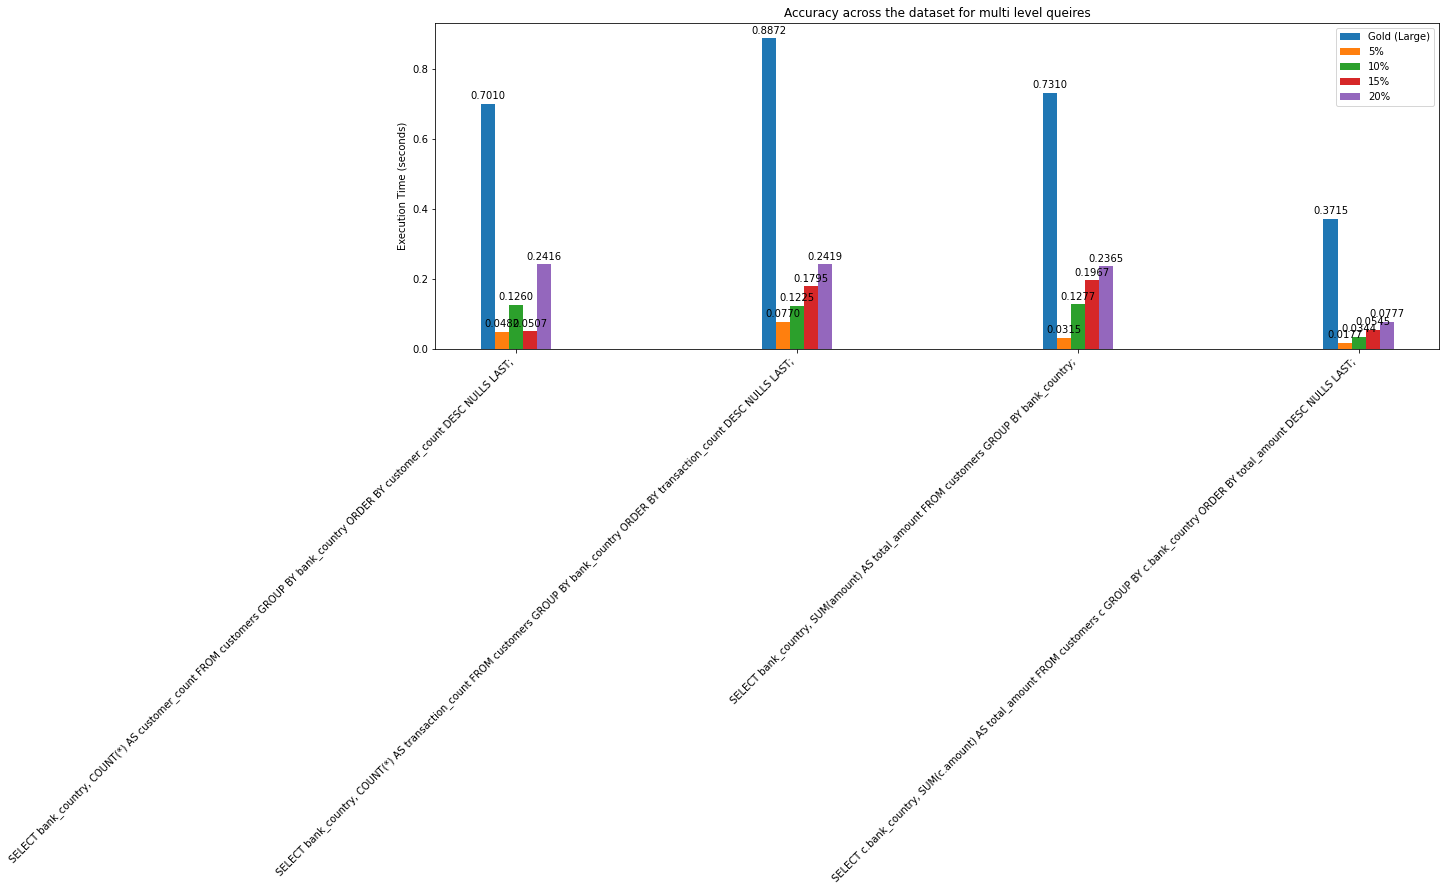

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_execution_time_all():
    # Retrieve all unique queries from the gold standard metrics
    queries = list(gold_standard_metrics.keys())
    queries.sort()  # Optional: sort alphabetically

    # Initialize lists to hold execution times for each dataset
    gold_times = []
    sample5_times = []
    sample10_times = []
    sample15_times = []
    sample20_times = []

    # Loop over each query and extract execution times
    for query in queries:
        # For Gold standard (Large Database)
        gold_time, _ = gold_standard_metrics.get(query, (None, None))
        gold_times.append(gold_time if gold_time is not None else 0)
        
        # For Sample 5% (list of dictionaries)
        s5 = next((item for item in sample_5_metrics if item.get("Query") == query), None)
        sample5_times.append(s5["Execution Time"] if s5 and s5.get("Execution Time") is not None else 0)
        
        # For Sample 10% (list of tuples: (query, exec_time, abs_error, percent_error, scaled_result, scaling_factor))
        s10 = next((item for item in sample_10_metrics if item[0] == query), None)
        sample10_times.append(s10[1] if s10 and s10[1] is not None else 0)
        
        # For Sample 15% (dictionary keyed by query)
        s15 = sample_15_metrics.get(query, None)
        sample15_times.append(s15["Execution Time"] if s15 and s15.get("Execution Time") is not None else 0)
        
        # For Sample 20% (list of tuples)
        s20 = next((item for item in sample_20_metrics if item[0] == query), None)
        sample20_times.append(s20[1] if s20 and s20[1] is not None else 0)

    # Increase spacing between groups by multiplying x positions
    group_spacing = 3.0
    x = np.arange(len(queries)) * group_spacing
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(18, 6))
    # Create grouped bars for each dataset
    rects_gold = ax.bar(x - 2 * bar_width, gold_times, bar_width, label='Gold (Large)')
    rects_5 = ax.bar(x - bar_width, sample5_times, bar_width, label='5%')
    rects_10 = ax.bar(x, sample10_times, bar_width, label='10%')
    rects_15 = ax.bar(x + bar_width, sample15_times, bar_width, label='15%')
    rects_20 = ax.bar(x + 2 * bar_width, sample20_times, bar_width, label='20%')

    ax.set_ylabel("Execution Time (seconds)")
    ax.set_title("Accuracy across the dataset for multi level queires")
    ax.set_xticks(x)
    ax.set_xticklabels(queries, rotation=45, ha='right')
    ax.legend()

    # Annotate each bar with its execution time value
    def annotate_bars(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f"{height:.4f}",
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom")
    
    annotate_bars(rects_gold)
    annotate_bars(rects_5)
    annotate_bars(rects_10)
    annotate_bars(rects_15)
    annotate_bars(rects_20)

    fig.tight_layout()
    plt.savefig("AccuracyforMultiLevelQueries.png")
    plt.show()

# Call the visualization function to see the execution time grouped bar chart.
visualize_execution_time_all()
